
# GDELT DOC 2.0 — Quick Verification Notebook

This notebook loads your saved Parquet files, inspects schema and coverage, checks duplicates,
shows samples, aggregates daily counts per symbol, and lists top domains.

**Instructions**:
1. Set `base_dir` below to your folder, e.g. `./work/data/gdelt` (as in your run log).
2. Run all cells.


In [1]:

from pathlib import Path
import pandas as pd
import numpy as np
from datetime import timezone
import matplotlib.pyplot as plt

# 1) EDIT THIS: path to your GDELT Parquet outputs
base_dir = Path("../../work/data/gdelt_v2")  # <-- change if needed

assert base_dir.exists(), f"Directory not found: {base_dir.resolve()}"

# 2) Read files
parquet_files = sorted(base_dir.glob("gdelt_doc_*.parquet"))
assert parquet_files, f"No parquet files found in {base_dir.resolve()}"

merged_files = [p for p in parquet_files if p.name.startswith("gdelt_doc_all_")]
symbol_files = [p for p in parquet_files if p not in merged_files]

dfs = []
for p in symbol_files:
    try:
        df = pd.read_parquet(p)
        df["__source_file"] = p.name
        dfs.append(df)
    except Exception as e:
        print(f"[WARN] Failed to read {p}: {e}")

assert dfs, "No per-symbol parquet files could be read."
df = pd.concat(dfs, ignore_index=True)

# Parse seendate
if "seendate" in df.columns:
    df["seendate"] = pd.to_datetime(df["seendate"], errors="coerce", utc=True)
else:
    df["seendate"] = pd.NaT

# Ensure symbol
if "symbol" not in df.columns:
    def infer_symbol_from_file(name: str) -> str:
        parts = name.split("_")
        if len(parts) > 2:
            return parts[2]
        return "UNKNOWN"
    df["symbol"] = df["__source_file"].apply(infer_symbol_from_file)

df["date"] = df["seendate"].dt.date
if "domain" not in df.columns:
    df["domain"] = None

print("[INFO] Loaded rows:", len(df))
print("[INFO] Symbols:", sorted(df["symbol"].dropna().unique().tolist()))
print("[INFO] Date range UTC:", df["seendate"].min(), "→", df["seendate"].max())

df.head(5)


[INFO] Loaded rows: 11416
[INFO] Symbols: ['BNB', 'BTC', 'ETH', 'SOL']
[INFO] Date range UTC: 2025-08-22 11:45:00+00:00 → 2025-09-05 11:15:00+00:00


,title,url,domain,language,seendate,socialimage,sourcecountry,isduplicate,date,symbol,keep,keep_reason,__source_file
0,Australia orders audit of crypto trading giant...,https://japantoday.com/category/business/austr...,japantoday.com,English,2025-08-22 21:30:00+00:00,,Japan,None,2025-08-22,BNB,True,symbol_anchor,gdelt_doc_filtered_BNB_2025-08-22_2025-09-05.p...
1,Binance Australian arm told by watchdog to app...,https://www.proactiveinvestors.co.uk/companies...,proactiveinvestors.co.uk,English,2025-08-22 14:00:00+00:00,https://cdn.proactiveinvestors.com/eyJidWNrZXQ...,United Kingdom,None,2025-08-22,BNB,True,symbol_anchor,gdelt_doc_filtered_BNB_2025-08-22_2025-09-05.p...
2,Crypto central bank ? How Binance is becoming ...,https://www.dnaindia.com/insights/report-crypt...,dnaindia.com,English,2025-08-22 13:15:00+00:00,https://cdn.dnaindia.com/sites/default/files/s...,India,None,2025-08-22,BNB,True,symbol_anchor,gdelt_doc_filtered_BNB_2025-08-22_2025-09-05.p...
3,Ethena approves BNB as first eligible collater...,https://invezz.com/news/2025/08/22/ethena-appr...,invezz.com,English,2025-08-22 13:00:00+00:00,https://invezz.com/wp-content/uploads/2025/08/...,United Kingdom,None,2025-08-22,BNB,True,symbol_anchor,gdelt_doc_filtered_BNB_2025-08-22_2025-09-05.p...
4,Australia orders audit of crypto trading giant...,https://www.thedigitalcourier.com/news/nationa...,thedigitalcourier.com,English,2025-08-22 12:00:00+00:00,https://bloximages.newyork1.vip.townnews.com/t...,United States,None,2025-08-22,BNB,True,symbol_anchor,gdelt_doc_filtered_BNB_2025-08-22_2025-09-05.p...


In [2]:

# Null checks
nulls = df.isna().sum().sort_values(ascending=False).to_frame("null_count")
nulls.head(20)


,null_count
isduplicate,11416
keep,8644
keep_reason,8644
url,0
title,0
seendate,0
language,0
domain,0
socialimage,0
date,0


In [3]:

# Duplicate stats
dup_by_url = df.duplicated(subset=["url"]).sum() if "url" in df.columns else None
dup_by_url_symbol = df.duplicated(subset=["url", "symbol"]).sum() if "url" in df.columns else None
pd.DataFrame([{
    "duplicate_rows_by_url": int(dup_by_url) if dup_by_url is not None else None,
    "duplicate_rows_by_url_and_symbol": int(dup_by_url_symbol) if dup_by_url_symbol is not None else None
}])


,duplicate_rows_by_url,duplicate_rows_by_url_and_symbol
0,8509,7094


In [4]:

# Per-symbol counts
per_symbol = df.groupby("symbol").size().sort_values(ascending=False).to_frame("rows").reset_index()
per_symbol


,symbol,rows
0,BTC,6204
1,ETH,2932
2,SOL,1484
3,BNB,796


In [5]:

# Daily counts per symbol
daily_counts = (
    df.dropna(subset=["date"])
      .groupby(["date", "symbol"]).size()
      .unstack(fill_value=0)
      .sort_index()
)
daily_counts.tail(10)


symbol,BNB,BTC,ETH,SOL
date,,,,
2025-08-27,54,718,306,160
2025-08-28,74,474,234,154
2025-08-29,62,546,240,150
2025-08-30,30,324,110,68
2025-08-31,22,174,50,32
2025-09-01,62,302,116,72
2025-09-02,94,624,352,92
2025-09-03,68,500,188,88
2025-09-04,74,540,234,140


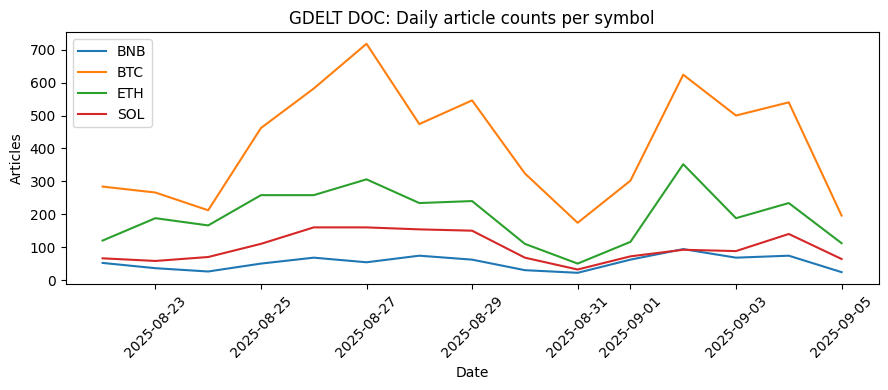

In [6]:

# Plot daily counts
plt.figure(figsize=(9,4))
for col in daily_counts.columns:
    plt.plot(daily_counts.index, daily_counts[col], label=col)
plt.legend()
plt.title("GDELT DOC: Daily article counts per symbol")
plt.xlabel("Date")
plt.ylabel("Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:

# Top domains overall
top_domains = (
    df["domain"].dropna().value_counts().head(25).to_frame("count").reset_index(names="domain")
)
top_domains


,domain,count
0,finance.yahoo.com,1332
1,newsbtc.com,988
2,biztoc.com,716
3,coindesk.com,560
4,benzinga.com,504
5,coinspeaker.com,328
6,bravenewcoin.com,322
7,themarketsdaily.com,268
8,fxstreet.com,260
9,fool.com,252


In [8]:

# Top domains per symbol (long-form)
dom_per_sym = (
    df.dropna(subset=["domain"])
      .groupby(["symbol", "domain"]).size()
      .reset_index(name="count")
      .sort_values(["symbol", "count"], ascending=[True, False])
)
dom_per_sym.head(25)


,symbol,domain,count
78,BNB,newsbtc.com,100
34,BNB,finance.yahoo.com,74
21,BNB,coindesk.com,60
22,BNB,coinspeaker.com,38
15,BNB,bravenewcoin.com,24
11,BNB,benzinga.com,20
52,BNB,insidebitcoins.com,20
24,BNB,cyprus-mail.com,18
7,BNB,banklesstimes.com,16
37,BNB,finanznachrichten.de,16


In [9]:

# Recent 50 articles (clean view)
cols = [c for c in ["symbol", "seendate", "title", "domain", "url", "__source_file"] if c in df.columns]
sample_df = df[cols].sort_values("seendate", ascending=False).head(50)
sample_df


,symbol,seendate,title,domain,url,__source_file
10831,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,cambodiantimes.com,http://www.cambodiantimes.com/news/278548127/t...,gdelt_doc_raw_all_2025-08-22_2025-09-05.parquet
10830,BNB,2025-09-05 11:15:00+00:00,Trump World Liberty token drops 12 % in debut ...,bignewsnetwork.com,http://www.bignewsnetwork.com/news/278548127/t...,gdelt_doc_raw_all_2025-08-22_2025-09-05.parquet
3078,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,heraldglobe.com,http://www.heraldglobe.com/news/278548127/trum...,gdelt_doc_raw_BNB_2025-08-22_2025-09-05.parquet
3077,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,africaleader.com,http://www.africaleader.com/news/278548127/tru...,gdelt_doc_raw_BNB_2025-08-22_2025-09-05.parquet
3076,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,cambodiantimes.com,http://www.cambodiantimes.com/news/278548127/t...,gdelt_doc_raw_BNB_2025-08-22_2025-09-05.parquet
3075,BNB,2025-09-05 11:15:00+00:00,Trump World Liberty token drops 12 % in debut ...,bignewsnetwork.com,http://www.bignewsnetwork.com/news/278548127/t...,gdelt_doc_raw_BNB_2025-08-22_2025-09-05.parquet
10833,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,heraldglobe.com,http://www.heraldglobe.com/news/278548127/trum...,gdelt_doc_raw_all_2025-08-22_2025-09-05.parquet
10832,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,africaleader.com,http://www.africaleader.com/news/278548127/tru...,gdelt_doc_raw_all_2025-08-22_2025-09-05.parquet
2160,BTC,2025-09-05 11:00:00+00:00,Bitcoin : Are Bulls Poised to Turn Support Int...,investing.com,https://www.investing.com/analysis/bitcoin-are...,gdelt_doc_filtered_all_2025-08-22_2025-09-05.p...
9329,BTC,2025-09-05 11:00:00+00:00,4 Top Stock - Investing Themes : ETFs to Buy f...,businessinsider.com,https://www.businessinsider.com/stock-market-e...,gdelt_doc_raw_all_2025-08-22_2025-09-05.parquet


In [15]:
# Recent 50 articles (clean view)
cols = [c for c in ["symbol", "seendate", "title", "url"] if c in df.columns]
sample_df = df[cols].sort_values("seendate", ascending=False).head(50)
sample_df

,symbol,seendate,title,url
10831,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,http://www.cambodiantimes.com/news/278548127/t...
10830,BNB,2025-09-05 11:15:00+00:00,Trump World Liberty token drops 12 % in debut ...,http://www.bignewsnetwork.com/news/278548127/t...
3078,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,http://www.heraldglobe.com/news/278548127/trum...
3077,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,http://www.africaleader.com/news/278548127/tru...
3076,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,http://www.cambodiantimes.com/news/278548127/t...
3075,BNB,2025-09-05 11:15:00+00:00,Trump World Liberty token drops 12 % in debut ...,http://www.bignewsnetwork.com/news/278548127/t...
10833,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,http://www.heraldglobe.com/news/278548127/trum...
10832,BNB,2025-09-05 11:15:00+00:00,Trump - backed crypto $WLFI falls on first day...,http://www.africaleader.com/news/278548127/tru...
2160,BTC,2025-09-05 11:00:00+00:00,Bitcoin : Are Bulls Poised to Turn Support Int...,https://www.investing.com/analysis/bitcoin-are...
9329,BTC,2025-09-05 11:00:00+00:00,4 Top Stock - Investing Themes : ETFs to Buy f...,https://www.businessinsider.com/stock-market-e...


In [16]:
# ! pip install tabulate

In [17]:
from tabulate import tabulate

print(tabulate(
    sample_df[['symbol','seendate','title', 'url']].head(50),   # lấy 20 dòng đầu
    headers='keys',
    tablefmt='pretty',
    showindex=False
))


+--------+---------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| symbol |         seendate          |                                                                                                          title                                                                                                          |                                                                                                   url                                                                                                    |
+--------+---------------------------+------------------------------------------